In [ ]:
#@title Установка нужных библиотек
!wget 'https://drive.google.com/uc?export=download&id=1oSFOP0j25OZAuhD8YXxyQXNTdr2lUdtn' -O requirements.txt
!pip install -r requirements.txt

--2021-11-18 09:26:46--  https://drive.google.com/uc?export=download&id=1oSFOP0j25OZAuhD8YXxyQXNTdr2lUdtn
Resolving drive.google.com (drive.google.com)... 108.177.119.101, 108.177.119.100, 108.177.119.102, ...
Connecting to drive.google.com (drive.google.com)|108.177.119.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5p9427a665d7a869arc5ofmogj310dih/1637227575000/14904333240138417226/*/1oSFOP0j25OZAuhD8YXxyQXNTdr2lUdtn?e=download [following]
--2021-11-18 09:26:47--  https://doc-0g-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5p9427a665d7a869arc5ofmogj310dih/1637227575000/14904333240138417226/*/1oSFOP0j25OZAuhD8YXxyQXNTdr2lUdtn?e=download
Resolving doc-0g-c0-docs.googleusercontent.com (doc-0g-c0-docs.googleusercontent.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Connecting to doc-0g-c0-docs.googleusercontent.com (d

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

matplotlib.rcParams.update({'font.size': 14})
pd.set_option('display.max_columns', 10)

**Метрики** в машинном обучении нужны для того, чтобы оценивать качество работы модели, чтобы понимать, а насколько модель хорошо запомнила закономерности из обучающей выборки.  

Сегодня продолжаем рассматривать метрики для **задачи классификации**. Для такой задачи хочется, чтобы наши модели как можно чаще предсказывали верную метку класса объекта.

<img src='https://static.javatpoint.com/tutorial/machine-learning/images/classification-algorithm-in-machine-learning.png' width=600>


## Получение данных

Будем считать новую метрику PR-AUC на задаче бинарной классификации. Возьмем датасет из стандартных наборов данных в `sklearn` по предсказанию рака груди `load_breast_cancer` и выведем информацию по нему.

Есть 569 объект и 30 признаков, так же здесь представлено описание признаков и целевых значений.

In [ ]:
from sklearn.datasets import load_breast_cancer


data = load_breast_cancer()

print(data['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

Обернем данные в датафрейм для наглядности.

In [ ]:
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])

X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,...,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,...,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,...,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,...,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,...,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,...,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,...,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,...,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,...,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,...,0.86810,0.9387,0.2650,0.4087,0.12400


И посмотрим, на целевую переменную:   
- 212 нулей - это класс злокачественной опухоли (Malignant).   
- А 357 единиц - класс доброкачественной опухоли (Benign).

In [ ]:
y.value_counts()

1    357
0    212
dtype: int64

Разобьем выборку на обучающую и тестовую. Из исходного набора возьмем только два случайных признака, а на тест возьмем только 9 объектов для простоты подсчета метрик.

In [ ]:
from sklearn.model_selection import train_test_split


np.random.seed(5)
features = np.random.randint(X.shape[1], size=2)


X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, features], y, test_size=9, random_state=4)

Получили выборку для которой будем считать метрику PR AUC.

In [ ]:
X_test

,mean area,smoothness error
340,641.2,0.004577
382,447.8,0.005042
300,1217.0,0.006056
262,947.8,0.006717
363,838.1,0.007257
157,880.2,0.003443
120,403.3,0.006040
139,384.8,0.011270
99,642.5,0.008005


Шестеро из них относятся к классу 1, а трое к классу 0.

In [ ]:
y_test

340    1
382    1
300    0
262    0
363    1
157    1
120    1
139    1
99     0
dtype: int64

## Обучение модели

И обучим дерево решений на классификацию опухоли.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1, max_depth=5, min_samples_leaf=5)

tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

Наши модели машинного обучения на выходе могут давать метку класса, к которому принадлежит объект через метод predict.

In [ ]:
tree.predict(X_test)

array([1, 1, 0, 0, 0, 0, 1, 1, 1])

А так же вероятность принадлежности к каждому классу через метод predict_proba.

In [ ]:
tree.predict_proba(X_test)

array([[0.1509434 , 0.8490566 ],
       [0.03125   , 0.96875   ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.03370787, 0.96629213],
       [0.45454545, 0.54545455]])

Так как классов только два, то и видим 2 столбика, 1 столбик - это вероятность того, что объект является нулевым классом, а 2 столбик - это вероятность того, что объект первый класс.   
В сумме вероятности дают 1.   

К примеру, первый объект вероятней всего будет 1 классом (85% объект может быть 1 классом, и 15% объект может быть 0 классом), а третий объект со стопроцентной уверенностью будет 0 классом (нулевая вероятность быть 1 классом, и единичная вероятность быть 0 классом)

Оперируя вероятностями мы можем самостоятельно принимать решения выше или ниже какой отметки, объект становится нулевым классом или первым. По умолчанию такая отсечка равна 0.5.

Убедимся в этом. Руками поставим соответствующие классы на объекты с вероятностями, которые больше 0.5. То есть, если вероятность быть 1 классом, больше или равна 50%, то мы ставим объекту класс 1, если предсказанная вероятность быть 1 классом меньше 50%, то ставим объекту метку класса 0. Для этого мы взяли только первый столбик.

In [ ]:
pred_proba = tree.predict_proba(X_test)
pred_proba

array([[0.1509434 , 0.8490566 ],
       [0.03125   , 0.96875   ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.03370787, 0.96629213],
       [0.45454545, 0.54545455]])

In [ ]:
np.where(pred_proba[:, 1] >= 0.5, 1, 0)

array([1, 1, 0, 0, 0, 0, 1, 1, 1])

In [ ]:
tree.predict(X_test)

array([1, 1, 0, 0, 0, 0, 1, 1, 1])

Получили точно такие же предсказанные метки классов, как и были после метода predict, значит точно, по умолчанию в методах predict стоит отсечка в 0.5.

## Визуализация вероятностей

Визуализируем вероятности быть 1 классом наших 9 объектов, по оси абсцисс порядковый номер объектов, а по оси ординат вероятность быть первым классом и раскрасим их в зависимости от истинной метки класса.   
Оранжевые - объекты 0 класса, синие - объекты 1 класса.

При этом есть низкой вероятностью обладают объекты как первого класса, так и нулевого.

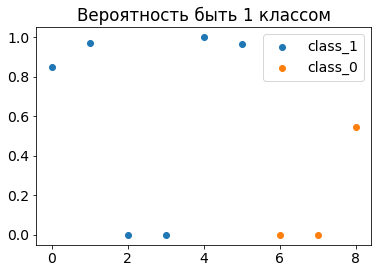

In [ ]:
class_1 = pred_proba[:, 1][y_test == 1]
class_0 = pred_proba[:, 1][y_test == 0]

plt.scatter(np.arange(len(class_1)), class_1, label='class_1')
plt.scatter(np.arange(len(class_1), len(class_1)+len(class_0)), class_0, label='class_0')
plt.title('Вероятность быть 1 классом')
plt.legend();

### Отсечка 0.5

Как мы с вами определились, по умолчанию отсечка равна 0.5. Отрисуем её тоже.   
По этой отсечке, у нас пять объектов будут классифицированы, как 1 класс, т.к. у них предсказанная вероятность больше 0.5, а четыре объекта будут классифицированы как 0 класс, т.к. их предсказанные вероятности меньше 0.5.  
При этом два объекта первого класса мы ошибочно посчитали нулевыми классами, предсказали им маленькие вероятности (0), сделали ошибки ложного пропуска False Negative.  
И ещё есть один объект с другой ошибкой - ложного срабатывания False Positive - это объект нулевого класса, который мы ошибочно посчитали объектом первого класса, т.к. ему предсказали большую вероятность быть первым классом (0.5454).

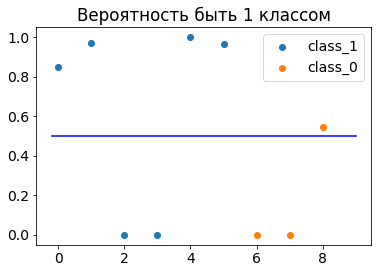

In [ ]:
threshold = 0.5
class_1 = pred_proba[:, 1][y_test == 1]
class_0 = pred_proba[:, 1][y_test == 0]

plt.scatter(np.arange(len(class_1)), class_1, label='class_1')
plt.scatter(np.arange(len(class_1), len(class_1)+len(class_0)), class_0, label='class_0')
plt.plot([-0.2, len(pred_proba[:, 1])], [threshold, threshold], c='b')
plt.title('Вероятность быть 1 классом')
plt.legend();

Можем для такого случая отрисовать матрицу ошибок, получается 2 TN, 4 TP, 1 FP и 2 FN.   
И выведем метрики точности и полноты, они довольно неплохие, но не идеальные.

Precision 0.8
Recall 0.6666666666666666


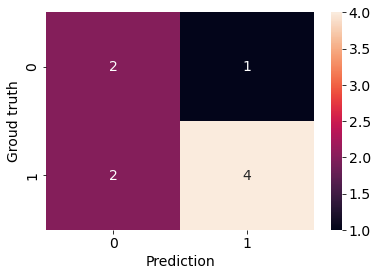

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score


pred = np.where(pred_proba[:, 1] >= threshold, 1, 0)

print('Precision', precision_score(y_test, pred))
print('Recall', recall_score(y_test, pred))

cm = confusion_matrix(y_test, pred)
f = sns.heatmap(cm, annot=True)
plt.ylabel('Groud truth')
plt.xlabel('Prediction');

### Отсечка 0.6

Данную отсечку можем менять, как захотим.

Если мы захотим увеличить чистоту классификации, то можем поднять отсечку, к примеру, до 0.6, в этом случае наша ошибка False Positive убирается, т.к. предсказанная вероятность теперь будет меньше. А значит больше нет ошибок ложного срабатывания и precision будет равен единице.

Precision 1.0
Recall 0.6666666666666666


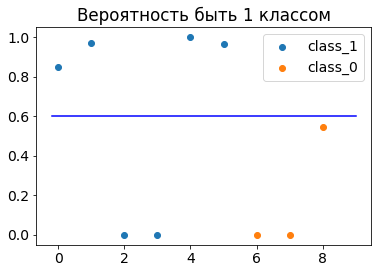

In [ ]:
threshold = 0.6

class_1 = pred_proba[:, 1][y_test == 1]
class_0 = pred_proba[:, 1][y_test == 0]

pred = np.where(pred_proba[:, 1] >= threshold, 1, 0)

print('Precision', precision_score(y_test, pred))
print('Recall', recall_score(y_test, pred))

plt.scatter(np.arange(len(class_1)), class_1, label='class_1')
plt.scatter(np.arange(len(class_1), len(class_1)+len(class_0)), class_0, label='class_0')
plt.plot([-0.2, len(pred_proba[:, 1])], [threshold, threshold], c='b')
plt.title('Вероятность быть 1 классом')
plt.legend();

Посчитаем матрицу ошибок и видим, что больше ошибок ложного срабатывания нет. А значит точность будет идеальной.

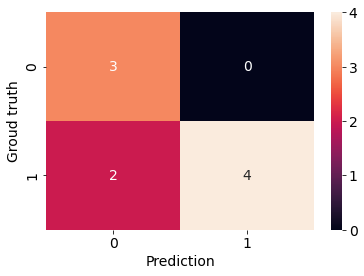

In [ ]:
cm = confusion_matrix(y_test, pred)
f = sns.heatmap(cm, annot=True)
plt.ylabel('Groud truth')
plt.xlabel('Prediction');

### Отсечка 0

И можем сделать по-другому: снизить отсечку до 0, тем самым будем классифицировать, как первый класс все объекты. А значит мы найдём все объекты первого класса. Ошибок ложного пропуска больше нет, метрика Recall будет единичная.

Precision 0.6666666666666666
Recall 1.0


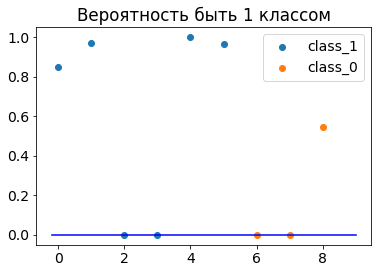

In [ ]:
threshold = 0

class_1 = pred_proba[:, 1][y_test == 1]
class_0 = pred_proba[:, 1][y_test == 0]

pred = np.where(pred_proba[:, 1] >= threshold, 1, 0)

print('Precision', precision_score(y_test, pred))
print('Recall', recall_score(y_test, pred))

plt.scatter(np.arange(len(class_1)), class_1, label='class_1')
plt.scatter(np.arange(len(class_1), len(class_1)+len(class_0)), class_0, label='class_0')
plt.plot([-0.2, len(pred_proba[:, 1])], [threshold, threshold], c='b')
plt.title('Вероятность быть 1 классом')
plt.legend();

Посчитаем матрицу ошибок и теперь ошибок ложного пропуска больше нет, ровно как и нет классификаций в нулевом классе.

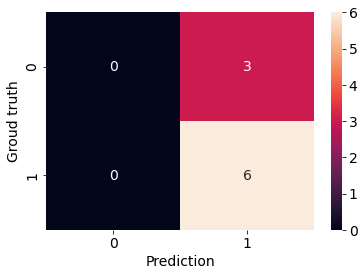

In [ ]:
cm = confusion_matrix(y_test, pred)
f = sns.heatmap(cm, annot=True)
plt.ylabel('Groud truth')
plt.xlabel('Prediction');

## PR-кривая (PR-curve)

На этих разных отсечках и строится метрика PR-кривая и PR-AUC. Из себя она представляет кривую, состоящую из точек с разными отсечками.  
Ниже пример PR-кривой на обучающей выборке. Для неё выбираются разные отсечки и считаются метрики precision и recall, далее откладываются точки. Прямая начинается с точки (0, 1), где нулевой recall и где единичный precision.

В идеале, когда PR-кривая проходит через точку (1, 1), где одновременно идеальный recall и такой же precision, но на реальных данных такого не встретишь, только на синтетических искусственных выборках.

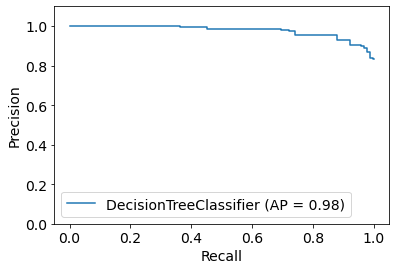

In [ ]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(tree, X_train, y_train)
plt.ylim([0, 1.1]);

Давайте посчитаем PR-кривую на тестовой выборке самостоятельно.

Объединим предсказанные вероятности быть первым классом и истинные целевые значения в датафрейм и отсортируем по пробе, вначале маленькие вероятности, затем большие.

In [ ]:
df_pred = pd.DataFrame({
    'proba': pred_proba[:, 1],
    'label': y_test
})

df_pred = df_pred.sort_values(by='proba')
df_pred

,proba,label
300,0.000000,0
262,0.000000,0
363,0.000000,1
157,0.000000,1
99,0.545455,0
340,0.849057,1
139,0.966292,1
382,0.968750,1
120,1.000000,1


В идеале должна существовать такая отсечка, выше которой находятся объекты только первого класса, а ниже находятся объекты нулевого класса, но в нашей задаче с такими предсказаниями не так, у нас такую границу провести не получится, всё равно будут либо ошибки ложного пропуска (FN), если поставим отсечку в 0.6, либо ошибки ложного срабатывания (FP), если поставим отсечку в 0.

### Отсечка 1

Все-таки переходим к построению PR-кривой и начнем с подсчета удачности метрик при самой высокой отсечке равной 1.  
В этом случае у нас 8 из 9 объектов будут классифицированы, как нулевой класс, т.к. у них у всех предсказанная вероятность меньше 1 и только один объект с пробой в 1, будет отнесен моделью к первому классу.

In [ ]:
threshold = 1
df_pred['pred_label'] = (df_pred['proba'] >= threshold).astype('int')

df_pred

,proba,label,pred_label
300,0.000000,0,0
262,0.000000,0,0
363,0.000000,1,0
157,0.000000,1,0
99,0.545455,0,0
340,0.849057,1,0
139,0.966292,1,0
382,0.968750,1,0
120,1.000000,1,1


Получаем, что у нас одна классификация и она верная, то есть $\text{precision} = \frac{TP}{TP + FP} = \frac{1}{1 + 0} = 1$

В свою очередь recall будет равен $\frac{TP}{TP + FN} = \frac{1}{1 + 5} = 0.167$, потому что нашли только одну единицу из 6 возможных.

Precision 1.0
Recall 0.16666666666666666


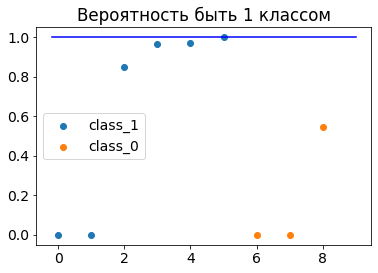

In [ ]:
class_1 = df_pred[df_pred.label == 1]
class_0 = df_pred[df_pred.label == 0]

pred = df_pred['pred_label']

precision = precision_score(df_pred['label'], pred)
recall = recall_score(df_pred['label'], pred)
print('Precision', precision)
print('Recall', recall)

plt.scatter(np.arange(len(class_1)), class_1['proba'], label='class_1')
plt.scatter(np.arange(len(class_1), len(class_1)+len(class_0)), class_0['proba'], label='class_0')
plt.plot([-0.2, len(df_pred)], [threshold, threshold], c='b')
plt.title('Вероятность быть 1 классом')
plt.legend();

Эти значения полноты и точности дают нам первую точку - (0.167, 1).

In [ ]:
recalls = [0]
precisions = [1]

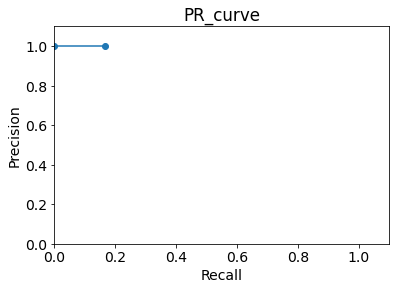

In [ ]:
recalls.append(recall)
precisions.append(precision)

plt.plot(recalls, precisions, marker='o')
plt.ylim([0, 1.1]);plt.xlim([0, 1.1])
plt.xlabel('Recall');plt.ylabel('Precision')
plt.title('PR_curve');

### Отсечка 0.968

Уменьшаем отсечку до 0.968, чтобы уже два объекта относились к первому классу по мнению модели.   
Теперь 7 из 9 объектов будут классифицированы, как нулевой класс, а два объекта имеют пробу больше нашей отсечки, значит они будут отнесены к первому классу.

In [ ]:
threshold = 0.968
df_pred['pred_label'] = (df_pred['proba'] >= threshold).astype('int')

df_pred

,proba,label,pred_label
300,0.000000,0,0
262,0.000000,0,0
363,0.000000,1,0
157,0.000000,1,0
99,0.545455,0,0
340,0.849057,1,0
139,0.966292,1,0
382,0.968750,1,1
120,1.000000,1,1


У нас две классификация и они верные, то есть $\text{precision} = \frac{TP}{TP + FP} = \frac{2}{2 + 0} = 1$

$\text{recall} =\frac{TP}{TP + FN} = \frac{2}{2 + 4} = 0.334$, потому что нашли две единицы из 6 возможных.

Precision 1.0
Recall 0.3333333333333333


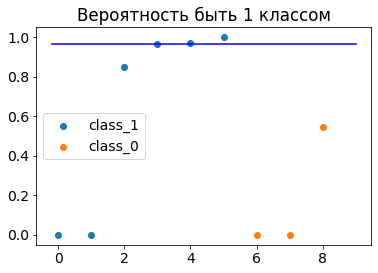

In [ ]:
class_1 = df_pred[df_pred.label == 1]
class_0 = df_pred[df_pred.label == 0]

pred = df_pred['pred_label']

precision = precision_score(df_pred['label'], pred)
recall = recall_score(df_pred['label'], pred)
print('Precision', precision)
print('Recall', recall)

plt.scatter(np.arange(len(class_1)), class_1['proba'], label='class_1')
plt.scatter(np.arange(len(class_1), len(class_1)+len(class_0)), class_0['proba'], label='class_0')
plt.plot([-0.2, len(df_pred)], [threshold, threshold], c='b')
plt.title('Вероятность быть 1 классом')
plt.legend();

Эти значения полноты и точности дают нам вторую точку - (0.334, 1).

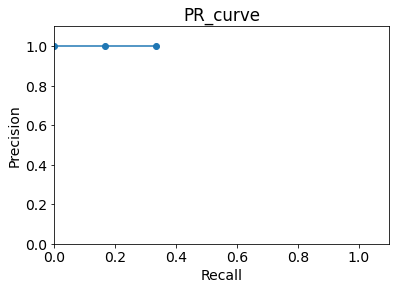

In [ ]:
recalls.append(recall)
precisions.append(precision)

plt.plot(recalls, precisions, marker='o')
plt.ylim([0, 1.1]);plt.xlim([0, 1.1])
plt.xlabel('Recall');plt.ylabel('Precision')
plt.title('PR_curve');

### Отсечка 0.966

Едем дальше и снижаем отсечку до 0.966, чтобы три объекта относились к первому классу.   
Теперь 6 из 9 объектов будут классифицированы, как нулевой класс, а три объекта будут отнесены к первому классу.

In [ ]:
threshold = 0.966
df_pred['pred_label'] = (df_pred['proba'] >= threshold).astype('int')

df_pred

,proba,label,pred_label
300,0.000000,0,0
262,0.000000,0,0
363,0.000000,1,0
157,0.000000,1,0
99,0.545455,0,0
340,0.849057,1,0
139,0.966292,1,1
382,0.968750,1,1
120,1.000000,1,1


У нас три классификация и до сих пор они все верные, $\text{precision} = \frac{TP}{TP + FP} = \frac{3}{3 + 0} = 1$

И полнота так же увеличивается $\text{recall} =\frac{TP}{TP + FN} = \frac{3}{3 + 3} = 0.5$.

Precision 1.0
Recall 0.5


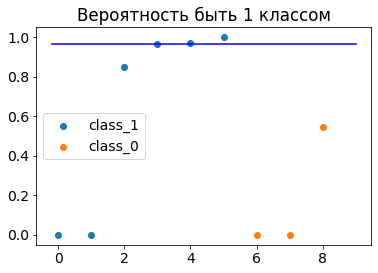

In [ ]:
class_1 = df_pred[df_pred.label == 1]
class_0 = df_pred[df_pred.label == 0]

pred = df_pred['pred_label']

precision = precision_score(df_pred['label'], pred)
recall = recall_score(df_pred['label'], pred)
print('Precision', precision)
print('Recall', recall)

plt.scatter(np.arange(len(class_1)), class_1['proba'], label='class_1')
plt.scatter(np.arange(len(class_1), len(class_1)+len(class_0)), class_0['proba'], label='class_0')
plt.plot([-0.2, len(df_pred)], [threshold, threshold], c='b')
plt.title('Вероятность быть 1 классом')
plt.legend();

Эти значения полноты и точности дают нам третью точку - (0.5, 1).

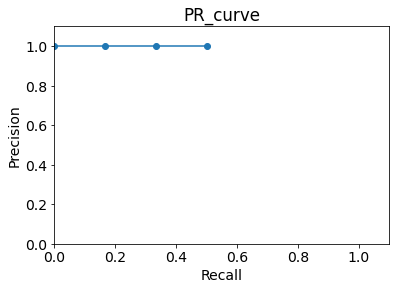

In [ ]:
recalls.append(recall)
precisions.append(precision)

plt.plot(recalls, precisions, marker='o')
plt.ylim([0, 1.1]);plt.xlim([0, 1.1])
plt.xlabel('Recall');plt.ylabel('Precision')
plt.title('PR_curve');

### Отсечка 0.84

Ещё делаем меньше отсечку, теперь она равна 0.84, четыре объекта относятся к первому классу по предсказанным вероятностям.   
5 из 9 объектов будут классифицированы, как нулевой класс, а четыре объекта классифицированы как первый класс.

In [ ]:
threshold = 0.84
df_pred['pred_label'] = (df_pred['proba'] >= threshold).astype('int')

df_pred

,proba,label,pred_label
300,0.000000,0,0
262,0.000000,0,0
363,0.000000,1,0
157,0.000000,1,0
99,0.545455,0,0
340,0.849057,1,1
139,0.966292,1,1
382,0.968750,1,1
120,1.000000,1,1


Четыре классификации и всё ещё не допустили ошибку ложного срабатывания (FP), $\text{precision} = \frac{TP}{TP + FP} = \frac{4}{4 + 0} = 1$

И полнота растёт $\text{recall} =\frac{TP}{TP + FN} = \frac{4}{4 + 2} = 0.667$, остается найти ещё две единицы, тогда recall будет единичным.

Precision 1.0
Recall 0.6666666666666666


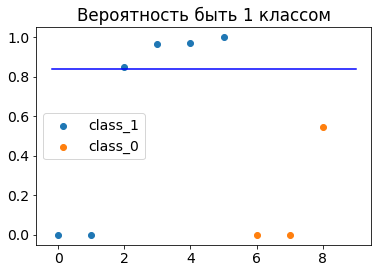

In [ ]:
class_1 = df_pred[df_pred.label == 1]
class_0 = df_pred[df_pred.label == 0]

pred = df_pred['pred_label']

precision = precision_score(df_pred['label'], pred)
recall = recall_score(df_pred['label'], pred)
print('Precision', precision)
print('Recall', recall)

plt.scatter(np.arange(len(class_1)), class_1['proba'], label='class_1')
plt.scatter(np.arange(len(class_1), len(class_1)+len(class_0)), class_0['proba'], label='class_0')
plt.plot([-0.2, len(df_pred)], [threshold, threshold], c='b')
plt.title('Вероятность быть 1 классом')
plt.legend();

Эти значения полноты и точности дают нам четвертую точку - (0.667, 1).

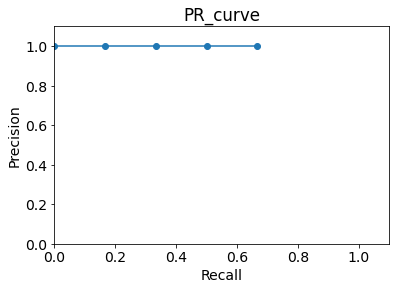

In [ ]:
recalls.append(recall)
precisions.append(precision)

plt.plot(recalls, precisions, marker='o')
plt.ylim([0, 1.1]);plt.xlim([0, 1.1])
plt.xlabel('Recall');plt.ylabel('Precision')
plt.title('PR_curve');

### Отсечка 0.54

Резкое снижение отсечки до значения 0.54, пять объектов относятся к первому классу по предсказанным вероятностям, в четыре к нулевому классу.   

In [ ]:
threshold = 0.54
df_pred['pred_label'] = (df_pred['proba'] >= threshold).astype('int')

df_pred

,proba,label,pred_label
300,0.000000,0,0
262,0.000000,0,0
363,0.000000,1,0
157,0.000000,1,0
99,0.545455,0,1
340,0.849057,1,1
139,0.966292,1,1
382,0.968750,1,1
120,1.000000,1,1


И наконец-то получаем ошибку ложного срабатывания (FP), объект нулевого класса по мнению модели принадлежит к первому классу с вероятностью 0.5454, что больше нашей отсечки, значит он получает метку первого класса, но ошибочно, точность больше неидеальная: $\text{precision} = \frac{TP}{TP + FP} = \frac{4}{4 + 1} = 0.8$

Да и полнота никак не увеличилась, новую единицу не нашли $\text{recall} =\frac{TP}{TP + FN} = \frac{4}{4 + 2} = 0.667$.

Precision 0.8
Recall 0.6666666666666666


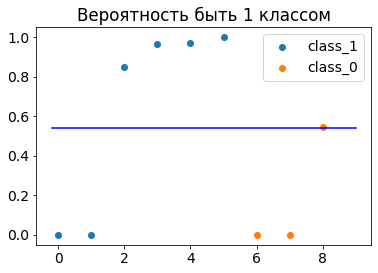

In [ ]:
class_1 = df_pred[df_pred.label == 1]
class_0 = df_pred[df_pred.label == 0]

pred = df_pred['pred_label']

precision = precision_score(df_pred['label'], pred)
recall = recall_score(df_pred['label'], pred)
print('Precision', precision)
print('Recall', recall)

plt.scatter(np.arange(len(class_1)), class_1['proba'], label='class_1')
plt.scatter(np.arange(len(class_1), len(class_1)+len(class_0)), class_0['proba'], label='class_0')
plt.plot([-0.2, len(df_pred)], [threshold, threshold], c='b')
plt.title('Вероятность быть 1 классом')
plt.legend();

Эти значения полноты и точности дают нам пятую точку - (0.667, 0.8).

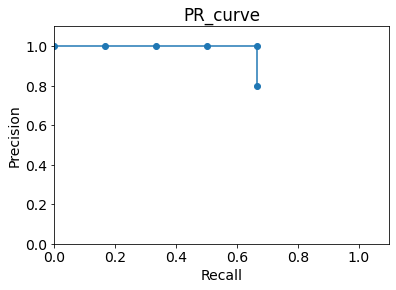

In [ ]:
recalls.append(recall)
precisions.append(precision)

plt.plot(recalls, precisions, marker='o')
plt.ylim([0, 1.1]);plt.xlim([0, 1.1])
plt.xlabel('Recall');plt.ylabel('Precision')
plt.title('PR_curve');

### Отсечка 0

Ещё хотим снизить отсечку в надежде увеличить recall, но получается, что у оставшихся объектов предсказанная вероятность нулевая, так что нам ничего не остается кроме как занулить отсечку и относить к первому классу все объекты из выборки.

In [ ]:
threshold = 0
df_pred['pred_label'] = (df_pred['proba'] >= threshold).astype('int')

df_pred

,proba,label,pred_label
300,0.000000,0,1
262,0.000000,0,1
363,0.000000,1,1
157,0.000000,1,1
99,0.545455,0,1
340,0.849057,1,1
139,0.966292,1,1
382,0.968750,1,1
120,1.000000,1,1


Имеем много ошибок ложного срабатывания -  3 штуки, но и истинных срабатываний прибавилось, их уже 6 штук $\text{precision} = \frac{TP}{TP + FP} = \frac{6}{6 + 3} = 0.667$

А вот полнота единичная, как и хотелось, нашли все объекты первого класса из нашей выборки $\text{recall} =\frac{TP}{TP + FN} = \frac{6}{6 + 0} = 1$.

Precision 0.6666666666666666
Recall 1.0


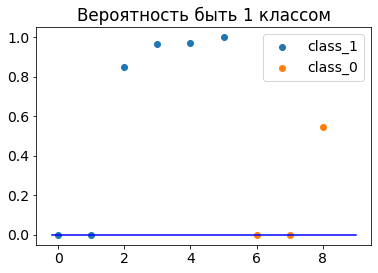

In [ ]:
class_1 = df_pred[df_pred.label == 1]
class_0 = df_pred[df_pred.label == 0]

pred = df_pred['pred_label']

precision = precision_score(df_pred['label'], pred)
recall = recall_score(df_pred['label'], pred)
print('Precision', precision)
print('Recall', recall)

plt.scatter(np.arange(len(class_1)), class_1['proba'], label='class_1')
plt.scatter(np.arange(len(class_1), len(class_1)+len(class_0)), class_0['proba'], label='class_0')
plt.plot([-0.2, len(df_pred)], [threshold, threshold], c='b')
plt.title('Вероятность быть 1 классом')
plt.legend();

Эти значения полноты и точности дают нам шестую точку - (1, 0.667).

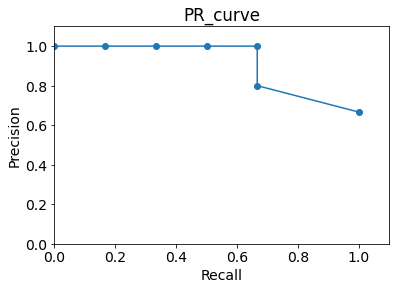

In [ ]:
recalls.append(recall)
precisions.append(precision)

plt.plot(recalls, precisions, marker='o')
plt.ylim([0, 1.1]);plt.xlim([0, 1.1])
plt.xlabel('Recall');plt.ylabel('Precision')
plt.title('PR_curve');

Такую же кривую мы могли бы получить через sklearn, если бы вызвали функцию `precision_recall_curve`, на выходе у неё список метрик precision, список метрик recall и список отсечек.

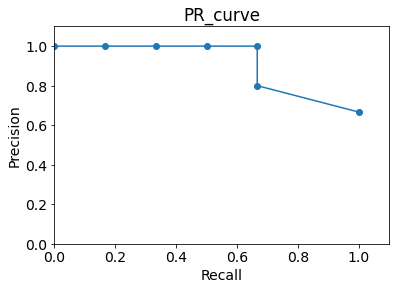

In [ ]:
prs, recs, _ = precision_recall_curve(y_test, pred_proba[:, 1])

plt.plot(recs, prs, marker='o')
plt.ylim([0, 1.1]);plt.xlim([0, 1.1])
plt.xlabel('Recall');plt.ylabel('Precision')
plt.title('PR_curve');

## PR-AUC

Так же мы можем узнать площадь под данными кривыми, результаты тоже будет одинаковыми.  
В данным случае считаем площадь через функцию `auc` (area under curve) из `sklearn`.

Получаем одинаковые метрики PR-AUC по нашей задаче.

In [ ]:
from sklearn.metrics import auc

auc(recs, prs), auc(recalls, precisions)

(0.911111111111111, 0.9111111111111111)

# Summary

В этом занятии посмотрели на PR-кривую и на площадь под ней - метрику PR-AUC. Данные метрики в большинстве своём можно считать только для задач бинарной классификации, т.к. мы оперируем вероятностями быть или не быть целевым классом. Но есть два подхода для решения задач многоклассовой классификации - OVR и OVO, как раз с помощью них и можно считать эти метрики для задач, где классов больше двух.

<table>

<tr>
<td>
Метрика
</td>

<td>
Область определения
</td>

<td>
Идеал
</td>

</tr>

<tr>
<td>
PR-curve (PR-кривая)
</td>

<td>

кривая начинается от точки (0,1) и заканчивается<br>в точке с координатой x равной 1.

</td>

<td>
Чем выше кривая, тем лучше алгоритм.
</td>

</tr>



<tr>
<td>
PR-AUC
</td>

<td>

[0, 1]

</td>

<td>
1

</td>

</tr>


<table>